In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://docs.quantum.ibm.com/run/primitives
# result = Sampler().run(circuits).result()

qiskit_runtime_service.__init__:INFO:2024-04-04 11:58:02,092: Default instance: quantum-explorer/group-4/project-1


In [3]:
!pip install mthree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 53.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 112.1 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 69.7 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.4.2
    Uninstalling websocket-client-1.4.2:
      Successfully uninstalled websocket-client-1.4.2
  Attempting uninstall: cython
    Found existing installation: Cython 0.29.32
    Uninstalling Cython-0.29.32:
      Successfully uninstalled Cython-0.29.32
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
quantum-serverless 0.9.0 requires clo

In [3]:
from qiskit import *
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
import mthree as m3
import numpy as np
import matplotlib.pyplot as plt

def myfunc(my_str):
    num_str = len(my_str)
    ind = num_str - 1 - np.where(np.array(list(my_str)) == '1')[0]
    qc = QuantumCircuit(num_str+1, name ='oracle')
    qc.cx(ind, num_str)
    U = qc.to_gate()
    return U


def BV(U):
    num_str = U.num_qubits - 1
    qc = QuantumCircuit(num_str + 1, num_str)
    qc.x(num_str)
    qc.h(range(num_str + 1))
    qc.barrier()
    qc.append(U, range(num_str+1))
    qc.barrier()
    qc.h(range(num_str))
    qc.measure(range(num_str), range(num_str))
    return qc

bv_all = []
bit_range = range(2, 10)
for k in bit_range:
    U = myfunc('1'*k)
    bv_all.append(BV(U))
    
backend = FakeSherbrooke()
shots = int(1e4)
trans_BVs = transpile(bv_all, backend, optimization_level=3)
counts = backend.run(trans_BVs, shots=shots).result().get_counts()

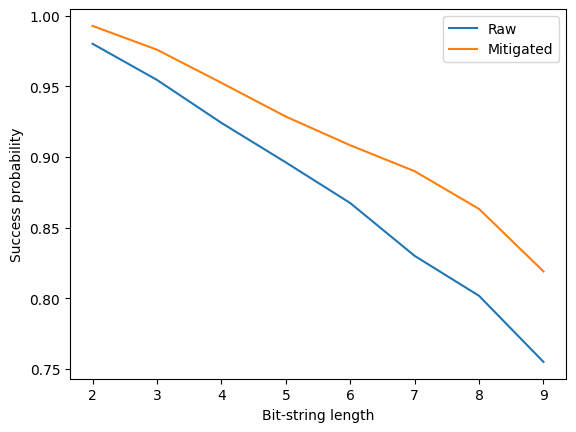

In [4]:
mappings = m3.utils.final_measurement_mapping(trans_BVs)
mit = m3.M3Mitigation(backend)
mit.cals_from_system(mappings)
quasis = mit.apply_correction(counts, mappings)

count_probs = [counts[idx].get('1'*num_bits)/shots for idx, num_bits in enumerate(bit_range)]
quasi_probs = [quasis[idx].get('1'*num_bits) for idx, num_bits in enumerate(bit_range)]

fig, ax = plt.subplots()
ax.plot(bit_range, count_probs, label='Raw')
ax.plot(bit_range, quasi_probs, label='Mitigated')
ax.set_ylabel('Success probability')
ax.set_xlabel('Bit-string length')
ax.legend();